# Natural Gas price Indicator

##*Discription* :
1. Produce a varying picture of existing price data as well as an extrapolation for an extra year .
2. Incase client needs an indicative price for long term storage contract.

### Importing data

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

In [24]:
df = pd.read_csv(r"/content/Nat_Gas.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [25]:
df['Dates']=df['Dates'].values
df['Prices']=df['Prices'].values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


### Plot

visualizing graph plotting prices across dates.

<ipython-input-26-627797872>:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date (df['Dates'] , df['Prices'] , '-')
<ipython-input-26-627797872>:2: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot_date (df['Dates'] , df['Prices'] , '-')


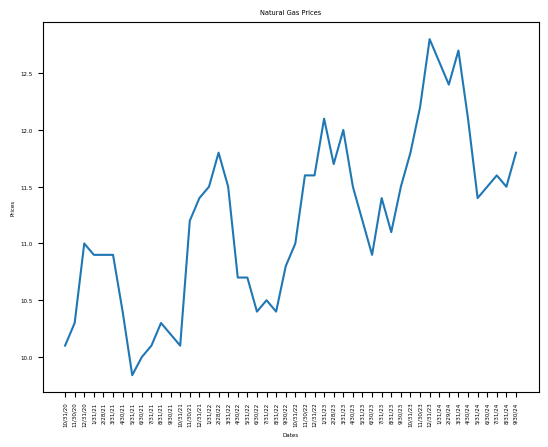

In [26]:
fig , ax = plt.subplots()
ax.plot_date (df['Dates'] , df['Prices'] , '-')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
ax.set_title('Natural Gas Prices')
ax.tick_params(axis = 'x' , rotation = 90)
plt.rcParams.update({'font.size': 4})
plt.show()

1. trend is upward , can use linear regression and then use sin funtion to fit each variation in year.


In [27]:
df['Dates'] = pd.to_datetime(df['Dates'])
start_date = df['Dates'].min()
end_date = df['Dates'].max()
print(start_date)
print(end_date)

2020-10-31 00:00:00
2024-09-30 00:00:00


<ipython-input-27-2623365575>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


### Model

In [28]:
from ast import Break
from datetime import date
# initalize empty list

months = []
year = start_date.year
month = start_date.month + 1

# dates required from start for interpolating

while True :
     current = date(year, month, 1) + timedelta(days=-1) # gets last day of the month
     months.append(current) #loop stops when current reaches end_date
     if current.month == end_date.month and current.year == end_date.year:
      break

     else:
      month = ((month + 1) % 12) or 12
      if month == 1:
        year += 1
days_from_start = [(month_day - start_date.date()).days for month_day in months]





#### Regression model:
1. y = mx + c
2. calculating slope :
   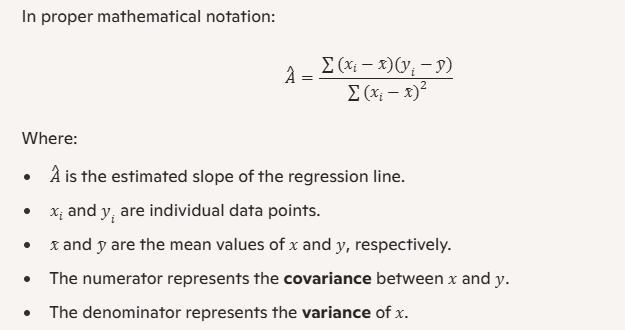
   3. intercept C(B) :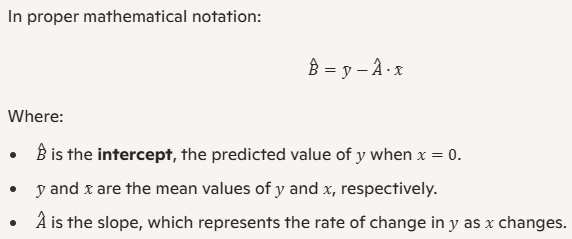

In [29]:
def simple_regression(x,y):
  x_slope = np.mean(x)
  y_slope = np.mean(y)
  slope = np.sum((x-x_slope)*(y-y_slope))/np.sum((x - x_slope)**2)
  intercept = y_slope - slope*x_slope
  return slope , intercept

In [30]:
prices = df['Prices'].values
time = np.array(days_from_start)
slope , intercept = simple_regression (time , prices)

Plotting linear trend

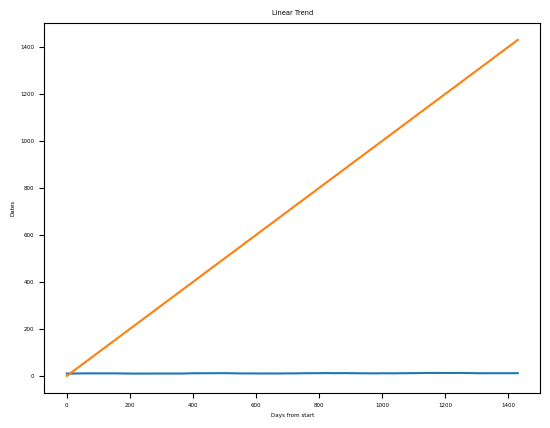

In [31]:
plt.plot(time , prices)
plt.plot(time , time + slope * intercept)
plt.xlabel('Days from start')
plt.ylabel('Dates')
plt.title('Linear Trend')
plt.show()

In [32]:
print(slope , intercept)

0.001282373598760221 10.29104112595228


In [33]:
# linear trend is captured  , now fitting intra year variation.
# use of natural gas : higher in winter & lower in summer (periodic trend at yearly level therefor sin function van be fitted.

sin_prices = prices - (time * slope + intercept) # removing linear trend to analyse seasonal trends
sin_time = np.sin(time * 2 * np.pi/365)
cos_time = np.cos(time * 2 * np.pi/365)

def bilinear_regression(y,x1,x2):
  slope1 = np.sum(y * x1) / np.sum(x1**2)
  slope2 = np.sum(y * x2) / np.sum(x2**2)
  return (slope1 , slope2)

slope1 , slope2 = bilinear_regression(sin_prices , sin_time , cos_time)
amplitude = slope1 ** 2 + slope2 ** 2
phase = np.arctan2(slope2 , slope1) # phase = tan^-1(slope2/slope1)



plotting smoothed estimate

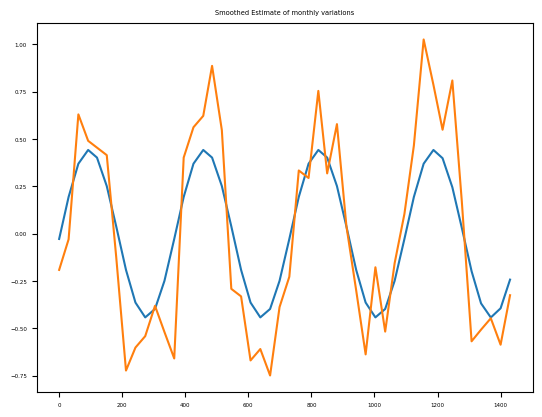

In [34]:
plt.plot(time , amplitude * np.sin(time * 2 * np.pi/365 + phase))
plt.plot(time , sin_prices)
plt.title("Smoothed Estimate of monthly variations")
plt.show()

Defining interpolation / extrapolation functions.

In [35]:
def interpolate(date):
  days = (date - pd.Timestamp(start_date)).Days
  if days in days_from_start:
    return prices[days_from_start.index(days)]
  else:
    return amplitude * np.sin(days * 2 * np.pi/365 + phase) + days * slope + intercept

In [36]:
# creating a continous date range

continous_date_range = pd.date_range(start = pd.Timestamp(start_date) , end = pd.Timestamp(end_date) , freq = 'D')


In [45]:
# fitting model into sin curve :

# convert values to np array

x = np.array(days_from_start)
y = np.array(prices)

fit_amplitude = np.sqrt(slope1**2 + slope2 **2)
fit_shift = np.arctan2(slope2,slope1)
fit_slope , fit_intercept = simple_regression(x , y - fit_amplitude * np.sin(x*2*np.pi/365 + fit_shift))


### Visualisation

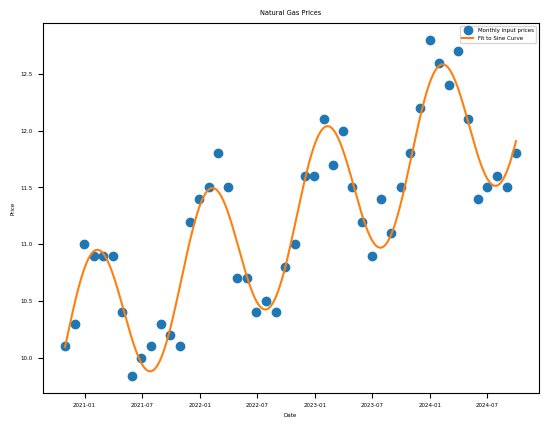

In [50]:
Dates = df['Dates'].values
plt.plot(Dates ,y,'o', label ="Monthly input prices")
plt.plot(continous_date_range, fit_amplitude * np.sin((continous_date_range - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continous_date_range - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()
